## carter_taxa_barcharts.ipynb

In [1]:
from qiime2 import Artifact
from qiime2.plugins import feature_table
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(style='whitegrid')
plt.rcParams["font.family"] = "Times New Roman"

### Prepare data

#### Import collapsed DADA2/SILVA tables and metadata

In [3]:
path_b_map = '/Users/luke.thompson/carter/metadata/14693_analysis_mapping_cleaned_bleaching.txt'
path_c_map = '/Users/luke.thompson/carter/metadata/14693_analysis_mapping_cleaned_corallimorph.txt'
path_b5 = '/Users/luke.thompson/carter/post-tourmaline/bleaching_biom_dada2_pe_filtered_level5.qza'
path_c5 = '/Users/luke.thompson/carter/post-tourmaline/corallimorph_biom_dada2_pe_filtered_level5.qza'

In [4]:
df_b_map = pd.read_csv(path_b_map, sep='\t', index_col=0)
df_c_map = pd.read_csv(path_c_map, sep='\t', index_col=0)

#### Import filtered biom tables, convert to relative frequency, convert to DataFrame

In [5]:
b_table_filt = Artifact.load(path_b5)
b_table_filt_rel_result = feature_table.methods.relative_frequency(table=b_table_filt)
b_table_filt_rel = b_table_filt_rel_result.relative_frequency_table
df_b5_filt_rel = b_table_filt_rel.view(pd.DataFrame)

In [6]:
c_table_filt = Artifact.load(path_c5)
c_table_filt_rel_result = feature_table.methods.relative_frequency(table=c_table_filt)
c_table_filt_rel = c_table_filt_rel_result.relative_frequency_table
df_c5_filt_rel = c_table_filt_rel.view(pd.DataFrame)

#### Explore metadata

In [7]:
# bleached_2016 is really recovered_2016 (but don't change metadata)
df_b_map.coral_health_plus_year.value_counts().sort_index()

bleached_2015    56
bleached_2016    52
healthy_2015     64
healthy_2016     68
Name: coral_health_plus_year, dtype: int64

In [8]:
# corallimorph positions: 1,2=healthy, 3,4=interaction zone, 5,6=invaded
df_c_map.position_plus_year.value_counts().sort_index()

1_2015    37
1_2016    28
2_2015    17
3_2015    36
3_2016    28
4_2015    36
4_2016    28
5_2015    17
5_2016     1
6_2015    34
6_2016    27
Name: position_plus_year, dtype: int64

In [9]:
# use zones instead of positions: H=healthy, IZ=interaction zone, IV=invaded
df_c_map.zone_plus_year.value_counts().sort_index()

AB_2015    54
AB_2016    28
CD_2015    72
CD_2016    56
EF_2015    51
EF_2016    28
Name: zone_plus_year, dtype: int64

#### Add metadata, average over species and treatment groups, sort taxa by total abundance

In [10]:
df_b5_filt_rel = df_b5_filt_rel.join(df_b_map[['host_scientific_name', 'coral_health_plus_year']])
df_b5_filt_rel_group = df_b5_filt_rel.groupby(['host_scientific_name', 'coral_health_plus_year']).mean()
df_b5_filt_rel_group = df_b5_filt_rel_group[df_b5_filt_rel_group.sum().sort_values(ascending=False).index]

In [11]:
df_c5_filt_rel = df_c5_filt_rel.join(df_c_map[['host_scientific_name', 'zone_plus_year']])
df_c5_filt_rel_group = df_c5_filt_rel.groupby(['host_scientific_name', 'zone_plus_year']).mean()
df_c5_filt_rel_group = df_c5_filt_rel_group[df_c5_filt_rel_group.sum().sort_values(ascending=False).index]

#### Select named groups with average relative abundance across all groups >=1%, create Others column with remaining percentage

In [12]:
plot_taxa_b = df_b5_filt_rel_group.loc[:, df_b5_filt_rel_group.mean() > 0.01]
plot_taxa_b.loc[:, 'Others'] = 1 - plot_taxa_b.sum(axis=1)

/Users/luke.thompson/miniconda3/envs/qiime2-2018.8/lib/python3.5/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/luke.thompson/miniconda3/envs/qiime2-2018.8/lib/python3.5/site-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [13]:
plot_taxa_c = df_c5_filt_rel_group.loc[:, df_c5_filt_rel_group.mean() > 0.01]
plot_taxa_c.loc[:, 'Others'] = 1 - plot_taxa_c.sum(axis=1)

/Users/luke.thompson/miniconda3/envs/qiime2-2018.8/lib/python3.5/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/luke.thompson/miniconda3/envs/qiime2-2018.8/lib/python3.5/site-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


#### Rename taxa to families

In [14]:
plot_taxa_b_cols = plot_taxa_b.columns.str.replace(
    r'.*;D_4__', '').str.replace(r'D_0__Bacteria;D_1__Proteobacteria;D_2__', '').str.replace(';__;__', '')
plot_taxa_b.columns = plot_taxa_b_cols

In [15]:
plot_taxa_c_cols = plot_taxa_c.columns.str.replace(
    r'.*;D_4__', '').str.replace(r'D_0__Bacteria;D_1__Proteobacteria;D_2__', '').str.replace(';__;__', '')
plot_taxa_c.columns = plot_taxa_c_cols
# consolidate unnamed taxa > 0.01% into Others
plot_taxa_c.Others = plot_taxa_c.Others + plot_taxa_c.uncultured + plot_taxa_c.D_0__Bacteria
plot_taxa_c.drop(['uncultured', 'D_0__Bacteria'], axis=1, inplace=True)

/Users/luke.thompson/miniconda3/envs/qiime2-2018.8/lib/python3.5/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/luke.thompson/miniconda3/envs/qiime2-2018.8/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Barplots

#### Colors

In [16]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', 
          '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', 
          '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

# https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/

#### Bleaching

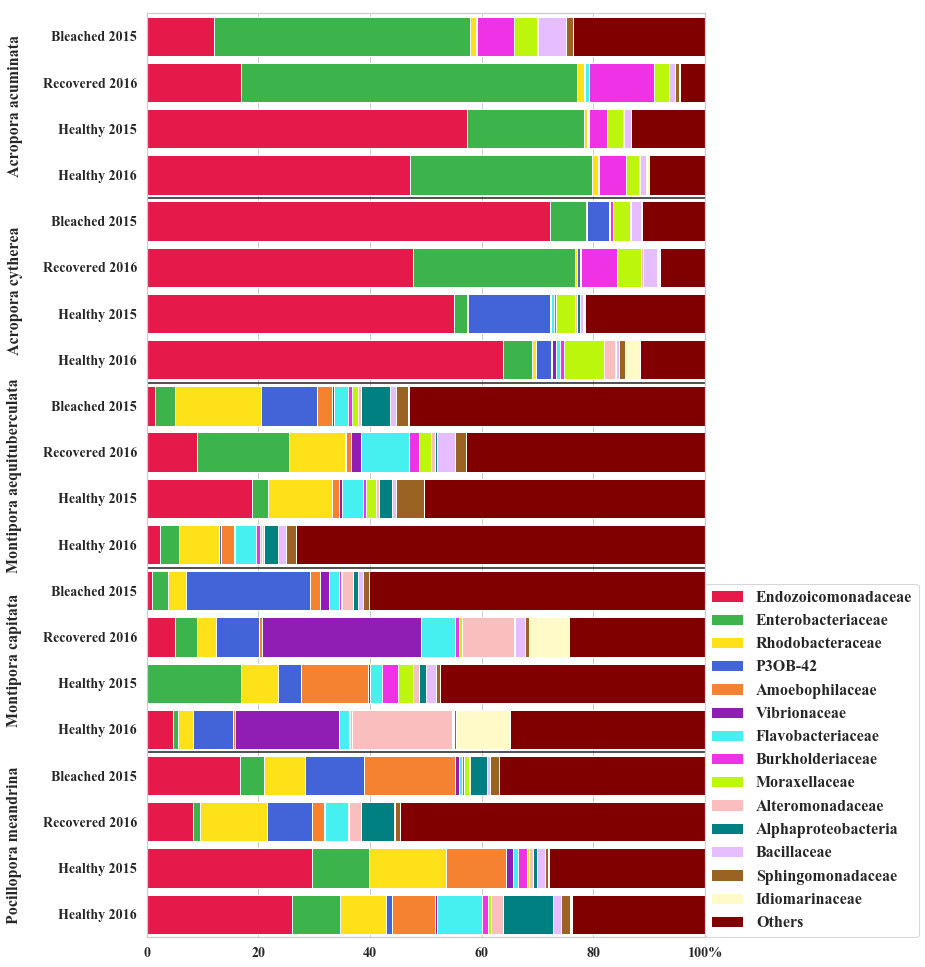

In [17]:
fig, ax = plt.subplots(figsize=(10,17))
height = 0.85
labels_rename = {'bleached_2015': 'Bleached 2015', 'bleached_2016': 'Recovered 2016',
                 'healthy_2015': 'Healthy 2015', 'healthy_2016': 'Healthy 2016'}
labels = [labels_rename[x] for x in plot_taxa_b.index.get_level_values(1)]
species_labels = plot_taxa_b.index.get_level_values(0)[::4]

for i in range(plot_taxa_b.shape[1]):
    ax.barh(y=range(plot_taxa_b.shape[0]), width=plot_taxa_b.iloc[:,i], 
            height=height, left=plot_taxa_b.iloc[:,0:i].sum(axis=1), color=colors[i])

ax.set_yticks(range(plot_taxa_b.shape[0]))
ax.set_yticklabels(labels, size=14)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticklabels(['0', '20', '40', '60', '80', '100%'], size=14)
ax.set_ylim([-0.5, 19.5])
ax.set_xlim([0, 1])
ax.legend(plot_taxa_b.columns, loc=(1, 0), fontsize=16)
for i in range(len(species_labels)):
    ax.text(-0.25, 1.5+i*4, species_labels[i], fontsize=16, rotation=90, verticalalignment='center')
ax.invert_yaxis()
ax.hlines(np.arange(3.5,19.5,4), 0, 1)

fig.savefig('../figures/taxa_barplot_bleaching.pdf', bbox_inches = 'tight')

#### Corallimorph

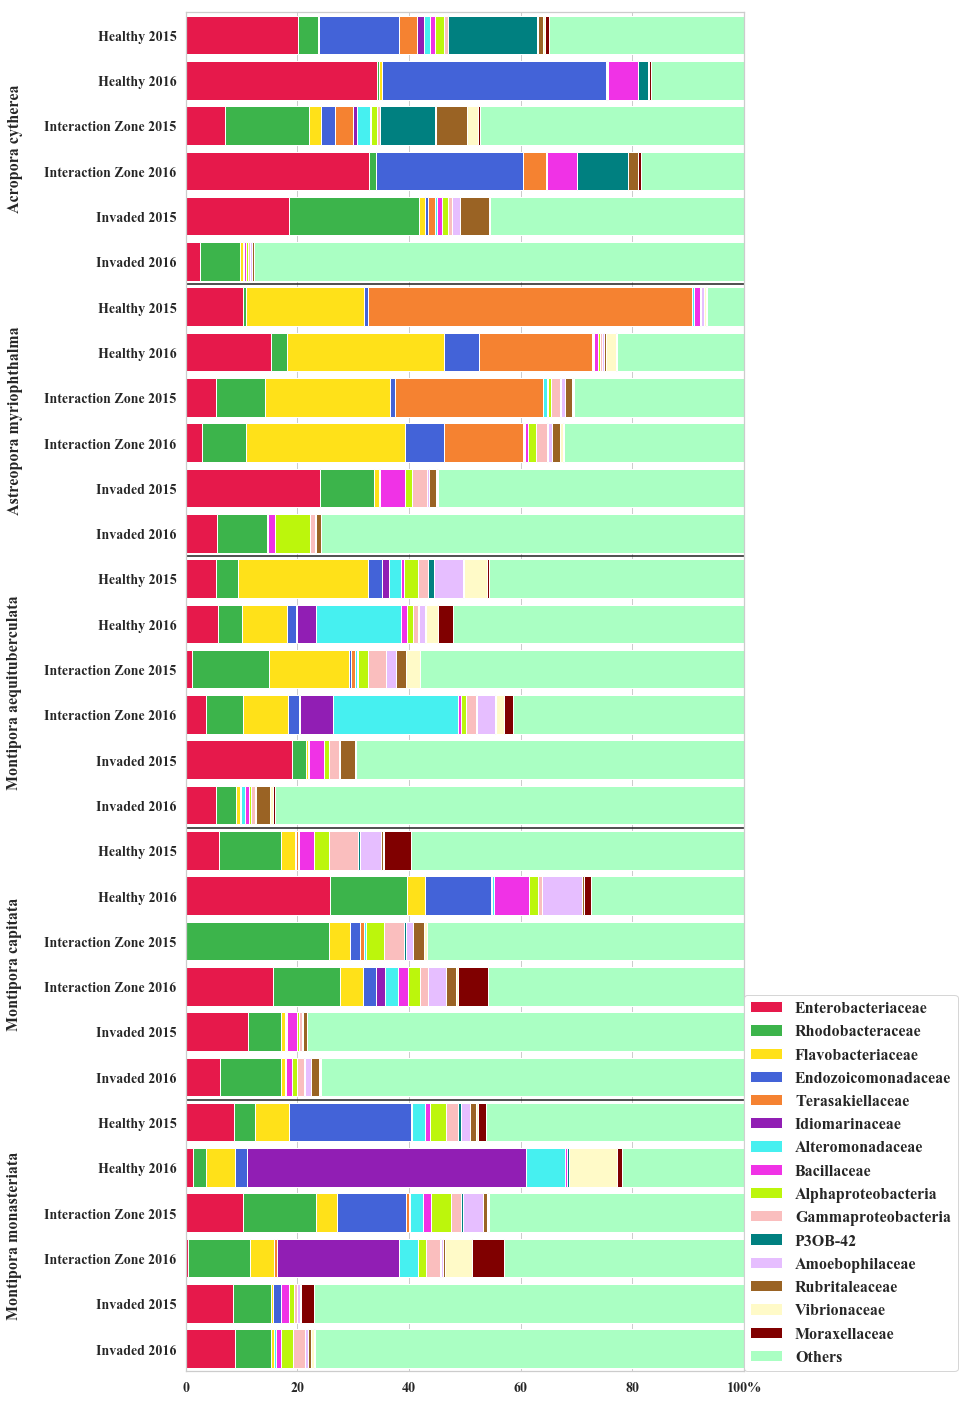

In [18]:
fig, ax = plt.subplots(figsize=(10,25))
height = 0.85
labels_rename = {'AB_2015': 'Healthy 2015', 'AB_2016': 'Healthy 2016',
                 'CD_2015': 'Interaction Zone 2015', 'CD_2016': 'Interaction Zone 2016',
                 'EF_2015': 'Invaded 2015', 'EF_2016': 'Invaded 2016'}
labels = [labels_rename[x] for x in plot_taxa_c.index.get_level_values(1)]
species_labels = plot_taxa_c.index.get_level_values(0)[::6]

for i in range(plot_taxa_c.shape[1]):
    ax.barh(y=range(plot_taxa_c.shape[0]), width=plot_taxa_c.iloc[:,i], 
            height=height, left=plot_taxa_c.iloc[:,0:i].sum(axis=1), color=colors[i])

ax.set_yticks(range(plot_taxa_c.shape[0]))
ax.set_yticklabels(labels)
ax.set_yticklabels(labels, size=14)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticklabels(['0', '20', '40', '60', '80', '100%'], size=14)
ax.set_ylim([-0.5, 29.5])
ax.set_xlim([0, 1])
ax.legend(plot_taxa_c.columns, loc=(1, 0), fontsize=16)
for i in range(len(species_labels)):
    ax.text(-0.32, 2.5+i*6, species_labels[i], fontsize=16, rotation=90, verticalalignment='center')
ax.invert_yaxis()
ax.hlines(np.arange(5.5,29.5,6), 0, 1)

fig.savefig('../figures/taxa_barplot_corallimorph.pdf', bbox_inches = 'tight')